<a href="https://colab.research.google.com/github/Harley7Damian/PhawAI_2025/blob/NLP/NLP_TF_Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Clasificación de Emociones con Qwen (Prompting)**
**Autor:** Mayerly Damián Gavino

**Fecha:** 26-08-25

**Objetivo:** Este notebook implementa la clasificación de emociones en tweets del dataset EmoEvent utilizando el modelo Qwen (Qwen/Qwen2.5-0.5B-Instruct) mediante técnicas de prompting (zero-shot y few-shot). Se analizarán las métricas de rendimiento por cada categoría de emoción y se generará una matriz de confusión.


In [2]:
# ============================
# @title Montar Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

# ============================
# 2. Clonar repositorio oficial
# ============================
%cd /content/drive/MyDrive/

!git clone https://github.com/fmplaza/EmoEvent.git
%cd EmoEvent

Mounted at /content/drive
/content/drive/MyDrive
fatal: destination path 'EmoEvent' already exists and is not an empty directory.
/content/drive/MyDrive/EmoEvent


##**2. Carga del Modelo Qwen**
Aquí cargaremos el tokenizador y el modelo preentrenado Qwen. Este modelo está diseñado para seguir instrucciones, lo cual es ideal para el prompting.

In [3]:
# Importación de módulos necesarios
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [4]:
# @title 2.1. Definición del ID del Modelo y Carga
# Se usa el modelo Qwen 2.5 de 0.5B parámetros, version Instruct
model_id = "Qwen/Qwen2.5-0.5B-Instruct"

# Importación de módulos necesarios
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Cargar el tokenizador y el modelo desde Hugging Face Hub.
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

# @title 2.2. Mover el Modelo a la GPU
if torch.cuda.is_available():
    model.to("cuda")
    print("Modelo Qwen cargado y movido a la GPU.")
else:
    print("GPU no disponible. El modelo Qwen se ejecutará en CPU (más lento).")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Modelo Qwen cargado y movido a la GPU.


In [5]:
# @title 3.1. Función principal de chat para interacción con Qwen
def chat_with_qwen(messages, max_new_tokens=50, temperature=0.5, top_k=5, top_p=0.75):
    """
    Interactúa con el modelo Qwen para generar una respuesta basada en un historial de mensajes.
    Adaptada de la función `chat` de la fuente.
    """
    # Aplica la plantilla de chat del tokenizador para formatear los mensajes adecuadamente.
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # print(prompt) # Descomentar para ver el prompt generado

    # Tokeniza el prompt y lo mueve al dispositivo del modelo (CPU/GPU).
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Genera la respuesta del modelo.
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True, # Permite la exploración de respuestas si temperature > 0
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    # Decodifica la parte generada de la salida y la limpia.
    gen = out[inputs["input_ids"].shape[-1]:]
    return tokenizer.decode(gen, skip_special_tokens=True).strip()


In [6]:
# @title 3.2. Funciones para construir prompts de clasificación de emociones

# Lista de emociones esperadas en tu dataset (ajusta si tienes otras).
# Es crucial que Qwen conozca las categorías posibles.
#EMOCIONES_VALIDAS = ["alegría", "tristeza", "enfado", "sorpresa", "miedo", "enojo", "asco"]

def prompt_zero_shot_emotion(tweet):
    """
    Genera un prompt zero-shot para clasificar la emoción de un tweet.
    Adaptado de `prompt_zero_shot` de la fuente.
    """
    instruction = (
        "Eres un clasificador de emociones de tweets en español. "
        f"Clasifica la emoción del siguiente tweet en una de estas categorías: {', '.join(EMOCIONES_VALIDAS)}. "
        "Responde SOLO con la etiqueta de la emoción."
    )
    return [{"role": "system", "content": instruction},
            {"role": "user", "content": f"Tweet: '{tweet}'\nEmoción:"}]

def prompt_few_shot_emotion(examples, tweet_to_classify):
    """
    Genera un prompt few-shot con ejemplos para clasificar la emoción de un tweet.
    Adaptado de `prompt_few_shot` de la fuente.
    """
    instruction = (
        "Eres un clasificador de emociones de tweets en español. "
        f"Clasifica la emoción del tweet en una de estas categorías: {', '.join(EMOCIONES_VALIDAS)}. "
        "Responde SOLO con la etiqueta de la emoción."
    )
    messages = [{"role": "system", "content": instruction}]
    for example_tweet, example_emotion in examples:
        messages += [{"role": "user", "content": f"Tweet: '{example_tweet}'\nEmoción:"},
                     {"role": "assistant", "content": example_emotion}]
    messages += [{"role": "user", "content": f"Tweet: '{tweet_to_classify}'\nEmoción:"}]
    return messages

In [7]:
# @title 3.3. Función para normalizar la respuesta del modelo
def normalize_emotion_prediction(prediction, valid_emotions):
    """
    Normaliza la predicción del modelo para que coincida con una de las emociones válidas.
    Maneja casos donde el modelo puede generar texto adicional.
    """
    prediction_lower = prediction.lower().strip()
    for emotion in valid_emotions:
        if emotion in prediction_lower:
            return emotion
    return "desconocido" # O una clase por defecto para errores de parsing


In [8]:
# Definir emociones válidas según tu proyecto
EMOCIONES_VALIDAS = ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']

In [9]:
import pandas as pd

In [10]:
# @title 4.1. Carga del Dataset de Prueba
# Asumiendo que 'emoevent_es.csv' tiene columnas 'text' para el tweet y 'emotion' para la etiqueta.
# Si usas los archivos TSV, adapta la ruta y el método de lectura.
# Por ejemplo, df_test = pd.read_csv('splits/es/test.tsv', sep='\t')
import pandas as pd # Moved from cell hljG_jt8LPEy
try:
    # Leer dataset
    df_test = pd.read_csv('/content/drive/MyDrive/EmoEvent/splits/es/test.tsv', sep='\t')
    print("Columnas originales:", df_test.columns.tolist())
    print("Ejemplo de datos:\n", df_test.head())

    # Renombrar columnas para unificarlas (si esperas 'text' y 'emotion' más adelante)
    df_test = df_test.rename(columns={'tweet': 'text'})

    # Filtrar solo las emociones válidas si tu dataset contiene otras.
    df_test = df_test[df_test['emotion'].isin(EMOCIONES_VALIDAS)]
    print(f"Dataset filtrado a {len(df_test)} tweets con emociones válidas.")

except FileNotFoundError:
    print("Error: Asegúrate de que el archivo del dataset ('emoevent_es.csv' o 'test.tsv') esté en la ruta correcta.")
    print("La estructura esperada es: `splits/es/emoevent_es.csv` o `splits/es/test.tsv`.")

    # Dataset de ejemplo para continuar
    df_test = pd.DataFrame({
        'text': [
            "Qué alegría verte de nuevo!",
            "Estoy tan triste por la noticia.",
            "Esto me enfurece mucho.",
            "Qué sorpresa más agradable.",
            "Siento un gran miedo.",
            "Esto es neutral.", # Added to match the length of emotions
            "Otro tweet de ejemplo." # Added to match the length of emotions
        ],
        'emotion': ['joy', 'sadness', 'anger', 'surprise', 'fear', 'others', 'others'] # Adjusted emotions to match text length
    })
    print("\nUsando un dataset de prueba de ejemplo.")

Columnas originales: ['id', 'event', 'tweet', 'offensive', 'emotion']
Ejemplo de datos:
                                      id          event  \
0  16b25dfb-e284-4a58-b62c-8186fc082eb6  GameOfThrones   
1  2a80f6bf-4750-4783-9bc8-fdb8ff2b94c4  SpainElection   
2  1f477a6f-3559-41ee-8ec5-2e77aee53190   WorldBookDay   
3  838add70-748c-4635-8133-36ff0b05aeb0   WorldBookDay   
4  64e3dd59-ae5c-4b9b-bd29-987609eb95d8  SpainElection   

                                               tweet offensive emotion  
0  Señor de luz, ven a nosotros en nuestra oscuri...        NO  others  
1  Pues ya hemos votado tanto mi madre y yo #Elec...        NO  others  
2  #DiaDelLibro 😇⭐❤️🙏🙌😍🌷 sentimientos, viajar con...        NO     joy  
3  ¡Feliz #DíaDelLibro📚! ”El libro es fuerza, es ...        NO     joy  
4  Pues qué queréis que os diga, este sarao polít...        NO     joy  
Dataset filtrado a 1656 tweets con emociones válidas.


In [11]:
# @title 4.2. Preparación de Ejemplos para Few-Shot (opcional)
# Si decides usar few-shot, necesitas ejemplos del conjunto de entrenamiento o desarrollo.
# Puedes cargar el conjunto de entrenamiento y seleccionar aleatoriamente algunos ejemplos.
df_train = None
try:
    df_train = pd.read_csv('/content/drive/MyDrive/EmoEvent/splits/es/train.tsv', sep='\t')

    # Renombrar columna de texto para consistencia
    df_train = df_train.rename(columns={'tweet': 'text'})

    # Filtrar emociones válidas
    df_train = df_train[df_train['emotion'].isin(EMOCIONES_VALIDAS)]
    print(f"\nDataset de entrenamiento cargado para ejemplos few-shot: {len(df_train)} tweets.")

except FileNotFoundError:
    print("\nAdvertencia: Archivo de entrenamiento 'train.tsv' no encontrado para ejemplos few-shot.")
    print("Si deseas usar few-shot, asegúrate de que el archivo esté disponible.")


def get_few_shot_examples(df_source, num_examples_per_emotion=1):
    """
    Selecciona ejemplos para few-shot de manera balanceada por emoción.
    Retorna una lista de tuplas (texto, emoción).
    """
    if df_source is None or df_source.empty:
        return []

    few_shot_examples = []
    random.seed(42)  # reproducibilidad
    for emotion in EMOCIONES_VALIDAS:
        # Seleccionar tweets que contengan la emoción actual
        emotion_tweets = df_source[df_source['emotion'] == emotion]
        if not emotion_tweets.empty:
            # Seleccionar aleatoriamente el número deseado de ejemplos, sin reemplazo
            sampled_examples = emotion_tweets.sample(
                min(num_examples_per_emotion, len(emotion_tweets)),
                random_state=42
            )
            for _, row in sampled_examples.iterrows():
                few_shot_examples.append((row['text'], row['emotion']))

    # Mezclar para evitar sesgos por orden
    random.shuffle(few_shot_examples)
    return few_shot_examples


Dataset de entrenamiento cargado para ejemplos few-shot: 5723 tweets.


In [12]:
# Generar ejemplos para few-shot (ej. 2 ejemplos por emoción)
import random # Added import for random module
FEW_SHOT_EXAMPLES = get_few_shot_examples(df_train, num_examples_per_emotion=2)
if FEW_SHOT_EXAMPLES:
    print(f"\n✅ {len(FEW_SHOT_EXAMPLES)} ejemplos few-shot generados correctamente.")
    print("📌 Ejemplos de muestra:")
    for i, ex in enumerate(FEW_SHOT_EXAMPLES[10:15], start=1):
        print(f"  Ejemplo {i}: {ex}")
else:
    print("\n⚠️ No se generaron ejemplos few-shot.")
    print("👉 El sistema continuará en modo *zero-shot*.")


✅ 14 ejemplos few-shot generados correctamente.
📌 Ejemplos de muestra:
  Ejemplo 1: ('Lo que más miedo me da de lo de #Venezuela es que aquí en México, tienen hoy el poder total el grupo que justifica la Dictadura por el simple hecho de estar en contra de lo que ellos llaman Neoliberalismo. El "será lo que sea" es un escándalo', 'fear')
  Ejemplo 2: ('Si gana el PSOE, menuda fiesta de Putas y farlopa se van a pegar día sí, día también, a ver si por lo menos lo regulan y pagan impuestos.... Algo sacaremos. #ElecccionesGenerales28A', 'anger')
  Ejemplo 3: ('Lo siento Cayetana, pero No es No!... Al carrer 💁🏽\u200d♀️ #ElecccionesGenerales28A https://t.co/3my3AGzafq', 'anger')
  Ejemplo 4: ('Aunque es un alivio que no haya que lamentar daños humanos, en este caso los materiales son irremplazables. Muuuy triste 😭 #NotreDame https://t.co/ku2goMOqJ1', 'sadness')


In [14]:
# Definición de funciones de prompt

def prompt_zero_shot_emotion(tweet):
    """
    Genera un prompt para clasificación Zero-Shot de emociones.
    """
    return [
        {"role": "system", "content": "Eres un asistente experto en análisis de emociones en texto en español."},
        {"role": "user", "content": (
            f"Clasifica la emoción del siguiente texto en una de estas categorías: {', '.join(EMOCIONES_VALIDAS)}.\n\n"
            f"Texto: {tweet}\n\n"
            "Responde solo con la emoción."
        )}
    ]


def prompt_few_shot_emotion(few_shot_examples, tweet):
    """
    Genera un prompt para clasificación Few-Shot usando ejemplos balanceados.
    """
    # Construir la parte de ejemplos few-shot
    examples_text = ""
    for text, emotion in few_shot_examples:
        examples_text += f"Texto: {text}\nEmoción: {emotion}\n\n"

    return [
        {"role": "system", "content": "Eres un asistente experto en análisis de emociones en texto en español."},
        {"role": "user", "content": (
            f"A continuación tienes ejemplos de clasificación de emociones:\n\n"
            f"{examples_text}"
            f"Ahora clasifica la emoción del siguiente texto en una de estas categorías: {', '.join(EMOCIONES_VALIDAS)}.\n\n"
            f"Texto: {tweet}\n\n"
            "Responde solo con la emoción."
        )}
    ]

In [15]:
def chat_with_qwen(messages):
    """
    Envía mensajes a Qwen y devuelve la respuesta del modelo.
    `messages` debe ser una lista de diccionarios con {"role": "...", "content": "..."}.
    """
    # Convertimos a formato de prompt
    prompt = ""
    for m in messages:
        prompt += f"{m['role'].capitalize()}: {m['content']}\n"
    prompt += "Assistant:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=128)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Nos quedamos solo con lo que dice el "Assistant"
    if "Assistant:" in response:
        response = response.split("Assistant:")[-1].strip()
    return response

In [16]:
def normalize_emotion_prediction(raw_prediction, emociones_validas):
    """
    Normaliza la predicción de Qwen para que coincida con una emoción válida.
    - raw_prediction: texto generado por Qwen (puede contener explicaciones).
    - emociones_validas: lista de clases válidas.
    """
    if not raw_prediction:
        return "Desconocido"

    # Pasar a minúsculas y limpiar espacios
    pred = raw_prediction.strip().lower()

    # Buscar coincidencia exacta
    for emo in emociones_validas:
        if emo.lower() in pred:
            return emo

    # Si no hay coincidencia directa
    return "Desconocido"

In [17]:
print(df_test.shape)
print(df_test.head())

(1656, 5)
                                     id          event  \
0  16b25dfb-e284-4a58-b62c-8186fc082eb6  GameOfThrones   
1  2a80f6bf-4750-4783-9bc8-fdb8ff2b94c4  SpainElection   
2  1f477a6f-3559-41ee-8ec5-2e77aee53190   WorldBookDay   
3  838add70-748c-4635-8133-36ff0b05aeb0   WorldBookDay   
4  64e3dd59-ae5c-4b9b-bd29-987609eb95d8  SpainElection   

                                                text offensive emotion  
0  Señor de luz, ven a nosotros en nuestra oscuri...        NO  others  
1  Pues ya hemos votado tanto mi madre y yo #Elec...        NO  others  
2  #DiaDelLibro 😇⭐❤️🙏🙌😍🌷 sentimientos, viajar con...        NO     joy  
3  ¡Feliz #DíaDelLibro📚! ”El libro es fuerza, es ...        NO     joy  
4  Pues qué queréis que os diga, este sarao polít...        NO     joy  


In [18]:
# @title 5.1. Ejecución de la Clasificación (Zero-Shot)
print("\nIniciando clasificación Zero-Shot con Qwen...")

# Seleccionar una muestra pequeña (ejemplo: 100 tweets)
df_subset = df_test.sample(n=100, random_state=42).reset_index(drop=True)

predictions_zero_shot = []
true_labels = list(df_test['emotion'])  # Garantiza que esté disponible para ambos escenarios

# Iterar sobre la muestra seleccionada
for index, row in df_subset.iterrows():
    tweet = row['text']
    true_emotion = row['emotion']

    # Generar el prompt zero-shot
    messages = prompt_zero_shot_emotion(tweet)

    # Obtener la predicción del modelo
    raw_prediction = chat_with_qwen(messages)
    predicted_emotion = normalize_emotion_prediction(raw_prediction, EMOCIONES_VALIDAS)

    predictions_zero_shot.append(predicted_emotion)

    # Mostrar progreso cada 10 tweets
    if (index + 1) % 10 == 0 or (index + 1) == len(df_subset):
        print(f"[{index+1}/{len(df_subset)}] Procesados.")
        print(f"   Último tweet: {tweet[:60]}{'...' if len(tweet) > 60 else ''}")
        print(f"   → Predicción: {predicted_emotion} | Real: {true_emotion}\n")

# Resumen final
print("\n✅ Clasificación Zero-Shot completada.")
print(f"Total de tweets procesados: {len(df_subset)}")
print(f"Primeras 5 predicciones: {predictions_zero_shot[:5]}")


Iniciando clasificación Zero-Shot con Qwen...
[10/100] Procesados.
   Último tweet: No son los resultados ideales, pero todo pinta tan bien con ...
   → Predicción: disgust | Real: fear

[20/100] Procesados.
   Último tweet: Pero alguien duda de que el incendio de #NotreDame ha sido p...
   → Predicción: disgust | Real: others

[30/100] Procesados.
   Último tweet: Las repetí y no lloré... Definitivamente soy una perra sin c...
   → Predicción: anger | Real: others

[40/100] Procesados.
   Último tweet: Todo parecía perdido... y apareció Arya #GoT #JdT #GameofThr...
   → Predicción: disgust | Real: disgust

[50/100] Procesados.
   Último tweet: Entre el trono de hierro y el trono del gobierno, NO PUEDO R...
   → Predicción: disgust | Real: joy

[60/100] Procesados.
   Último tweet: Feliz #DíadelLibro #SanJorge Todo está en los libros https:/...
   → Predicción: joy | Real: others

[70/100] Procesados.
   Último tweet: Yo no sigo al Barcelona pero uno tiene que ser muy ciego o m...
   

--------


--- Resultados de Clasificación Zero-Shot ---
              precision    recall  f1-score   support

       anger       0.14      0.18      0.16        11
     disgust       0.05      0.75      0.10         4
        fear       0.00      0.00      0.00         2
         joy       0.00      0.00      0.00        21
      others       1.00      0.02      0.04        48
     sadness       0.25      0.10      0.14        10
    surprise       0.09      0.25      0.13         4

   micro avg       0.09      0.08      0.08       100
   macro avg       0.22      0.19      0.08       100
weighted avg       0.53      0.08      0.06       100



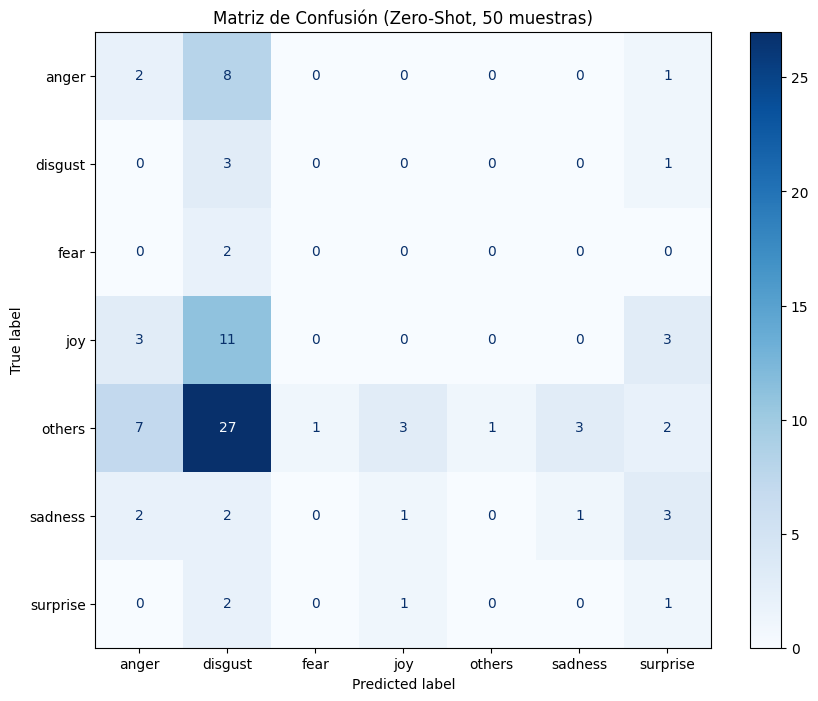

In [19]:
# @title 6.1. Reporte de Clasificación (Zero-Shot)
print("\n--- Resultados de Clasificación Zero-Shot ---")
# Import the necessary metrics from sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Also import matplotlib for plotting

# Usar solo los primeros 50 resultados para el reporte, corresponding to the subset used in cell 9zPbzsQbLmE4
true_labels_subset = list(df_subset['emotion'])
predictions_zero_shot_subset = predictions_zero_shot[:len(true_labels_subset)]

print(classification_report(
    true_labels_subset,
    predictions_zero_shot_subset,
    labels=EMOCIONES_VALIDAS,
    zero_division=0
))

# @title 6.2. Matriz de Confusión (Zero-Shot)
cm_zero_shot = confusion_matrix(true_labels_subset, predictions_zero_shot_subset, labels=EMOCIONES_VALIDAS)
disp_zero_shot = ConfusionMatrixDisplay(confusion_matrix=cm_zero_shot, display_labels=EMOCIONES_VALIDAS)

fig, ax = plt.subplots(figsize=(10, 8))
disp_zero_shot.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusión (Zero-Shot, 50 muestras)')
plt.show()

# @title 6.3. Reporte de Clasificación (Few-Shot - Opcional)
predictions_few_shot = [] # Initialize predictions_few_shot

if predictions_few_shot:
    # Assuming few-shot was run on the same subset if applicable
    predictions_few_shot_subset = predictions_few_shot[:len(true_labels_subset)]

    print("\n--- Resultados de Clasificación Few-Shot ---")
    print(classification_report(
        true_labels_subset,
        predictions_few_shot_subset,
        labels=EMOCIONES_VALIDAS,
        zero_division=0
    ))

    # @title 6.4. Matriz de Confusión (Few-Shot - Opcional)
    cm_few_shot = confusion_matrix(true_labels_subset, predictions_few_shot_subset, labels=EMOCIONES_VALIDAS)
    disp_few_shot = ConfusionMatrixDisplay(confusion_matrix=cm_few_shot, display_labels=EMOCIONES_VALIDAS)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp_few_shot.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Matriz de Confusión (Few-Shot, 100 muestras)')
    plt.show()

El modelo Zero-Shot muestra un rendimiento muy bajo en general. Aunque logró identificar algunos casos de anger y disgust, las métricas de precisión, recall y F1 son débiles en la mayoría de las clases. Especialmente, clases como joy y fear no fueron reconocidas en absoluto.

El micro promedio (0.08) y el weighted promedio (0.06 en F1) confirman que el modelo casi no logra generalizar en este conjunto de datos. Esto indica que, sin ajuste (fine-tuning), el modelo no es adecuado para esta tarea de clasificación emocional.

In [20]:
# @title 7.1. Análisis Cualitativo de Errores (Zero-Shot)
print("\n--- Análisis Cualitativo de Errores (Zero-Shot) ---")
misclassified_df_zero_shot = pd.DataFrame({
    'tweet': df_subset['text'], # Use df_subset instead of df_test
    'true_emotion': df_subset['emotion'], # Use df_subset instead of true_labels
    'predicted_emotion': predictions_zero_shot # predictions_zero_shot is already from the subset
})
misclassified_df_zero_shot = misclassified_df_zero_shot[misclassified_df_zero_shot['true_emotion'] != misclassified_df_zero_shot['predicted_emotion']]

if not misclassified_df_zero_shot.empty:
    print(f"\nSe encontraron {len(misclassified_df_zero_shot)} tweets mal clasificados (Zero-Shot).")
    print("\nAlgunos ejemplos de errores de clasificación:")
    for i in range(min(5, len(misclassified_df_zero_shot))):
        row = misclassified_df_zero_shot.iloc[i]
        print(f"Tweet: '{row['tweet']}'")
        print(f"  Real: {row['true_emotion']}, Predicho: {row['predicted_emotion']}")

    # Análisis de los tipos de errores (ej. confusión entre emociones)
    print("\nAnálisis de las confusiones más comunes:")
    error_pairs = misclassified_df_zero_shot.groupby(['true_emotion', 'predicted_emotion']).size().reset_index(name='count')
    print(error_pairs.sort_values(by='count', ascending=False).head(5))
else:
    print("\nNo se encontraron errores de clasificación en Zero-Shot (¡excelente!).")


# @title 7.2. Comparación Zero-Shot vs. Few-Shot (si aplica)
if predictions_few_shot:
    print("\n--- Comparación Zero-Shot vs. Few-Shot ---")
    # Calcular y mostrar métricas globales para ambos
    from sklearn.metrics import f1_score
    # Ensure that true_labels and predictions_zero_shot/few_shot are from the same subset
    true_labels_subset = list(df_subset['emotion'])
    predictions_zero_shot_subset = predictions_zero_shot[:len(true_labels_subset)]
    predictions_few_shot_subset = predictions_few_shot[:len(true_labels_subset)]


    f1_zero_shot = f1_score(true_labels_subset, predictions_zero_shot_subset, average='macro', labels=EMOCIONES_VALIDAS)
    f1_few_shot = f1_score(true_labels_subset, predictions_few_shot_subset, average='macro', labels=EMOCIONES_VALIDAS)
    print(f"F1-Macro Zero-Shot: {f1_zero_shot:.4f}")
    print(f"F1-Macro Few-Shot: {f1_few_shot:.4f}")

    if f1_few_shot > f1_zero_shot:
        print("El enfoque Few-Shot obtuvo un mejor rendimiento global.")
    elif f1_few_shot < f1_zero_shot:
        print("El enfoque Zero-Shot obtuvo un mejor rendimiento global (o el Few-Shot necesita más/mejores ejemplos).")
    else:
        print("Ambos enfoques tuvieron un rendimiento global similar.")

    # Puedes extender este análisis para ver qué emociones mejoran o empeoran con few-shot.


--- Análisis Cualitativo de Errores (Zero-Shot) ---

Se encontraron 92 tweets mal clasificados (Zero-Shot).

Algunos ejemplos de errores de clasificación:
Tweet: 'Felicidad es sinonimo de libro... #DíaDelLibro'
  Real: surprise, Predicho: joy
Tweet: 'Han contratado a un presentador de la tele en blanco y negro. 😱 #BarçaLevante #LaLiga https://t.co/k0BNCU3r3m'
  Real: joy, Predicho: anger
Tweet: 'Suenan los versos de Manuel Alcántara en boca de los miembros del Club de lectura de #FuenteVaqueros en el #DíaDelLibro https://t.co/twv3HgwTWn'
  Real: fear, Predicho: disgust
Tweet: 'Miéntras la vice USER aplaude a los encapuchados y rebeldes en #Venezuela, se aterra de los que acá también reclaman sus derechos!'
  Real: others, Predicho: disgust
Tweet: 'Lamentable celebración del barça, muy lamentable. #BarçaLevante #LaLiga #ForçaBarça'
  Real: others, Predicho: sadness

Análisis de las confusiones más comunes:
   true_emotion predicted_emotion  count
10       others           disgust     2

* El análisis cualitativo confirma que el modelo Zero-Shot comete un alto número de errores (92 de 100 casos).
* Los ejemplos muestran que el modelo confunde con frecuencia emociones distintas, como clasificar surprise como joy o fear como disgust.

La tabla de confusiones evidencia un patrón claro:
* La emoción others suele ser mal clasificada, sobre todo como disgust (27 veces) o anger (7 veces).
* joy también se confunde repetidamente con disgust (11 veces).


En general, el modelo tiende a sobrecargar la clase "disgust", asignándola incluso cuando no corresponde.

Esto refuerza que, sin un ajuste específico (fine-tuning), el modelo Zero-Shot no logra captar adecuadamente los matices emocionales en los tweets.